In [4]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
#warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# import atomic.features as fs
# import matplotlib.pyplot as plt
# import pattern.vis as vis
# import sklearn.mixture as mix
# import matplotsoccer as mps
# import atomic.vaep as vaep
# import pattern.action as pat
# import atomic.atomic_spadl as ato
# import pattern.wgmm as wgmm
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import numpy as np
from scipy.stats import multivariate_normal, vonmises
from scipy.stats import vonmises
import sklearn.cluster as cluster

class Gauss:
    def fit(self,X,w):
        self.mean = np.average(X,weights=w,axis=0)
        self.covariance = np.cov(X.T,aweights=w)
        return self
    
    def pdf(self,X):
        return multivariate_normal.pdf(X,mean=self.mean,cov=self.covariance)
    
    
class VonMises:
    def fit(self,alpha,w):
        sin = np.average(np.sin(alpha),weights=w,axis=0)
        cos = np.average(np.cos(alpha),weights=w,axis=0)
        
        self.loc = np.arctan2(sin,cos)
        self.R = np.sqrt(sin**2 + cos**2) # mean resultant length
        self.kappa = self.R * (2 - self.R**2) / (1 - self.R**2) # approximation for kappa
        return self
    
    def pdf(self,alpha):
        return vonmises.pdf(alpha,kappa=self.kappa, loc=self.loc).flatten()

class MixtureModel:
    
    def __init__(self,k,distribution = Gauss,max_iter=10,tol=1e-04):
        self.k = k
        self.distribution = distribution
        self.max_iter=max_iter
        self.tol=tol
    
    def no_sparsity(self,X,weights=None):
        if weights is None:
            weights = np.zeros(len(X)) + 1
        pos_weights_idx = weights > self.tol
        
        small_X = X[pos_weights_idx]
        small_w = weights[pos_weights_idx]
        return small_X, small_w
        
    def fit(self,X,weights=None,verbose=False):
        if weights is None:
            weights = np.zeros(len(X)) + 1
        pos_weights_idx = weights > self.tol
        X = X[pos_weights_idx]
        weights = weights[pos_weights_idx]
        
        responsibilities = self.init_responsibilities(X, weights)
        
        # learn models on initial weights
        self.priors = responsibilities.sum(axis=0)/responsibilities.sum()
        self.submodels = list(self.distribution().fit(X, weights * resp) for resp in responsibilities.T)
        
        iterations = range(self.max_iter) if not verbose else tqdm.tqdm(range(self.max_iter))
        self.loglikelihood = -np.inf
        for self._n_iter in iterations:
            # Expectation
            for i in range(self.k):
                responsibilities[:,i] = self.priors[i] * self.submodels[i].pdf(X)
                #responsibilities[:,i] = self.submodels[i].pdf(X)
                
            # enough improvement or not?
            new_loglikelihood = (weights * np.log(responsibilities.sum(axis=1))).sum()
            if new_loglikelihood > self.loglikelihood + self.tol:
                self.loglikelihood = new_loglikelihood
            else:
                break
            
#             if self._n_iter % 5 == 0:
#                 print(self._n_iter)
#                 for pdf in responsibilities.T:
#                     plt.scatter(X,pdf)
#                 plt.show()

            # normalize responsibilities such that each data point occurs with P=1
            responsibilities /= responsibilities.sum(axis=1)[:,np.newaxis]

            # Maximalization
            self.priors = responsibilities.sum(axis=0)/responsibilities.sum()
            for i in range(self.k):
                self.submodels[i].fit(X,weights * responsibilities[:,i])

        return self
    
    def init_responsibilities(self,X,weights):
        # initialize weights with KMeans
        n_samples,_ = X.shape
        labels = cluster.KMeans(n_clusters=self.k,n_init=1).fit_predict(X,sample_weight=weights)
        resp = np.zeros((n_samples,self.k))
        resp[np.arange(n_samples), labels] = 1
        return resp
    
    def predict_proba(self,X,weights=None):
        p = np.zeros((len(X),self.k))
    
        if weights is None:
            weights = np.zeros(len(X)) + 1
        pos_weights_idx = weights > self.tol
        X = X[pos_weights_idx]
        weights = weights[pos_weights_idx]
        
        pdfs = np.vstack([m.pdf(X) for m in self.submodels]).T
        resp = self.priors * pdfs
        probs = resp / resp.sum(axis=1)[:,np.newaxis]
        
        p[pos_weights_idx, :] =  (weights * probs.T).T
        return p

        
    def responsibilities(self,X,weights=None):
        X, weights = self.no_sparsity(X,weights)
        
        pdfs = np.vstack([m.pdf(X) for m in self.submodels]).T
        return self.priors * pdfs
    
    def likelihoods(self,X):
        return self.pdfs(X).sum(axis=1)
    
    def params(self):
        return list(m.__dict__ for m in self.submodels)

np.set_printoptions(suppress=True)

In [9]:
np.array([5,5]) * np.array([2,3])

array([10, 15])

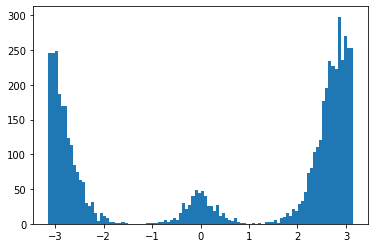

25 -5204.8145445146165 [{'loc': array([3.00475084]), 'R': array([0.89312626]), 'kappa': array([5.30743044])}, {'loc': array([-0.00968555]), 'R': array([0.94970049]), 'kappa': array([10.63370485])}]


array([[0.03481884, 0.06518116],
       [0.19999991, 0.00000009],
       [0.        , 0.        ],
       [0.39999998, 0.00000002],
       [0.43839216, 0.06160784]])

In [75]:
X = np.concatenate([np.random.vonmises(0,10,500),np.random.vonmises(3,5,5000)]).reshape(-1, 1)
plt.hist(X,bins=100)
plt.show()

model = MixtureModel(k=2,distribution=VonMises,max_iter=100)
model.fit(X)
print(model._n_iter,model.loglikelihood,model.params())

model.predict_proba(np.array([1,2,3,4,5]).reshape(-1,1),np.array([0.1,0.2,0,0.4,0.5]))

# import matplotlib.pyplot as plt
# # #hood = model.likelihoods(X)
# for pdf in model.pdfs(X).T:
#     plt.scatter(X,pdf)
# plt.show()

# model = MixtureModel(k=2,distribution=Gauss,max_iter=100)
# model.fit(X)
# print(model._n_iter,model.loglikelihood,model.params())

# import matplotlib.pyplot as plt
# # #hood = model.likelihoods(X)
# for pdf in model.pdfs(X).T:
#     plt.scatter(X,pdf)
# plt.show()

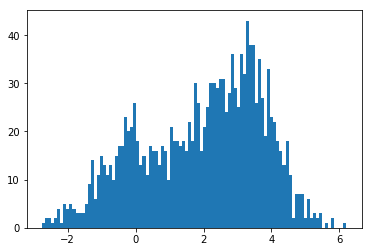

In [126]:
import matplotlib.pyplot as plt

X = np.concatenate([np.random.normal(0,1,500),np.random.normal(3,1,1000)]).reshape(-1, 1)
plt.hist(X,bins=100)
plt.show()

In [129]:
%%time

for i in range(2,3):
    model = MixtureModel(i,max_iter=1000)
    model.fit(X)
    print(i,model._n_iter,model.loglikelihood,model.params())

# import matplotlib.pyplot as plt
# #hood = model.likelihoods(X)
# for pdf in model.pdfs(X).T:
#     plt.scatter(X,pdf)
# plt.show()

2 48 -2877.660207432143 [{'mean': array([3.04367491]), 'covariance': array([[0.96544013]])}, {'mean': array([0.03355804]), 'covariance': array([[1.18152838]])}]
CPU times: user 78.1 ms, sys: 0 ns, total: 78.1 ms
Wall time: 91.4 ms


In [31]:
%%time
import sklearn.mixture as mix
model = mix.GaussianMixture(2)
model.fit(X)
model.means_,model.covariances_
model.__dict__

CPU times: user 325 ms, sys: 238 ms, total: 563 ms
Wall time: 92 ms


{'n_components': 2,
 'tol': 0.001,
 'reg_covar': 1e-06,
 'max_iter': 100,
 'n_init': 1,
 'init_params': 'kmeans',
 'random_state': None,
 'warm_start': False,
 'verbose': 0,
 'verbose_interval': 10,
 'covariance_type': 'full',
 'weights_init': None,
 'means_init': None,
 'precisions_init': None,
 'converged_': True,
 'weights_': array([0.6991055, 0.3008945]),
 'means_': array([[-0.73844581],
        [ 2.74492006]]),
 'covariances_': array([[[2.74412695]],
 
        [[0.07341916]]]),
 'precisions_cholesky_': array([[[0.60366765]],
 
        [[3.69058578]]]),
 'precisions_': array([[[ 0.36441463]],
 
        [[13.62042338]]]),
 'n_iter_': 17,
 'lower_bound_': -1.9014118363875248}

In [38]:
model.predict_proba([[2]])

array([[0.80925301, 0.19074699]])